# Calibration of multi-lab flow cytometry data

In [19]:
%matplotlib inline

In [20]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import arrow

In [21]:
from utils import (to_pickle, from_pickle, subsample, scale, model_to_dict, bilinear_interpolate)

In [22]:
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

In [23]:
plt.rcParams['font.size'] = 14

In [24]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [25]:
%%R
library(cremid)
library(DMwR)

## Load data

In [26]:
base_dir = os.path.join('/', 'data', 'flow')
seed = 234
labs = '001  004  007  010  013  044  003  006  008  011  031  101'.split()
subjects = ['F6901PRY_C', 'G6904VJT_E', 'K6902C85_A']
stims = '01 02 03 05 06 07 09 10 11'.split()
samples = ['%s%s' % (subject, stim) for subject in 'subjects' for stim in stims]
n = 10000

In [27]:
try:
    xsss = from_pickle('analysis/xsss_%d.pic' % seed)
except:
    np.random.seed(seed)
    xsss = {}
    for lab in labs:
        xss = {}
        for f in sorted(glob.glob(os.path.join(base_dir, 'EP3', 'files', '%s_*.npy' % lab))):
            path, filename = os.path.split(f)
            name, ext = os.path.splitext(filename)
            xs = np.load(f)
            xs = xs[(xs[:,0] > 0) & (xs[:,0] < 262143) & (xs[:,1] > 0) & (xs[:,1] < 262143), :]
            xs = subsample(xs, n)
            xss[name] = xs
            # xss[name] = xs[:, 2:] # skip scatters
        xsss[lab] = xss
    to_pickle(xsss, 'analysis/xsss_%d.pic' % seed)

In [28]:
markers = ['FSC-A', 'SSC-A', 'CD3', 'CD4', 'CD8', 'IFN+IL2']
# markers = ['CD3', 'CD4', 'CD8', 'IFN+IL2']
cols = range(len(markers))
dim_markers = [('FSC-A', 'SSC-A'), ('CD4', 'CD8'), ('CD3', 'IFN+IL2')]
# dim_markers = [('CD4', 'CD8'), ('CD3', 'IFN+IL2')]
dims = [(markers.index(p[0]), markers.index(p[1])) for p in dim_markers]

## Evaluate test_data

In [29]:
subjects = ['F6901PRY_C']
stims = ['11']

labels = []
test_data = []

for lab in labs:
   
    samples = ['%s_%s%s' % (lab, subject, stim) 
                            for subject in subjects for stim in stims]

    xss = xsss[lab]
    xs = {sample: xss[sample] for sample in samples}

    yss = np.array(list(xs.values())).squeeze()
    test_data.append(yss)
    labels.extend(samples)
test_data = np.array(test_data).squeeze()

In [30]:
Y = np.concatenate(test_data, axis=0)
C = np.concatenate([i*np.ones(len(test_data[0])) 
                    for i in range(1, len(test_data)+1)]).astype('int')

In [31]:
today = arrow.now().format('DD-MMM-YYYY')
# today = '29-May-2018'
ident = '%s:%s:%s:%s.rds' % (today,
                          '-'.join(np.unique(labs)),
                          '-'.join(np.unique(subjects)),
                          '-'.join(np.unique(stims)))
ident

'31-May-2018:001-003-004-006-007-008-010-011-013-031-044-101:F6901PRY_C:11.rds'

In [32]:
%%R -i Y,C,ident -o cal,mu,sd

YS <- scale(Y)
mu <- attributes(YS)$`scaled:center`
sd <- attributes(YS)$`scaled:scale`
           
ans <- Fit(YS, C)
cal <- Calibrate(ans)

#### Unscale data

In [33]:
mu = np.array(mu)
sd = np.array(sd)
YC = mu + sd*np.array(cal.rx2('Y_cal'))

## Visualize

### CD4/CD8 plots

In [34]:
data_orig = np.array([Y[C==c] for c in np.unique(C)])
data_cal = np.array([YC[C==c] for c in np.unique(C)])
data_sets = [data_orig, data_cal]

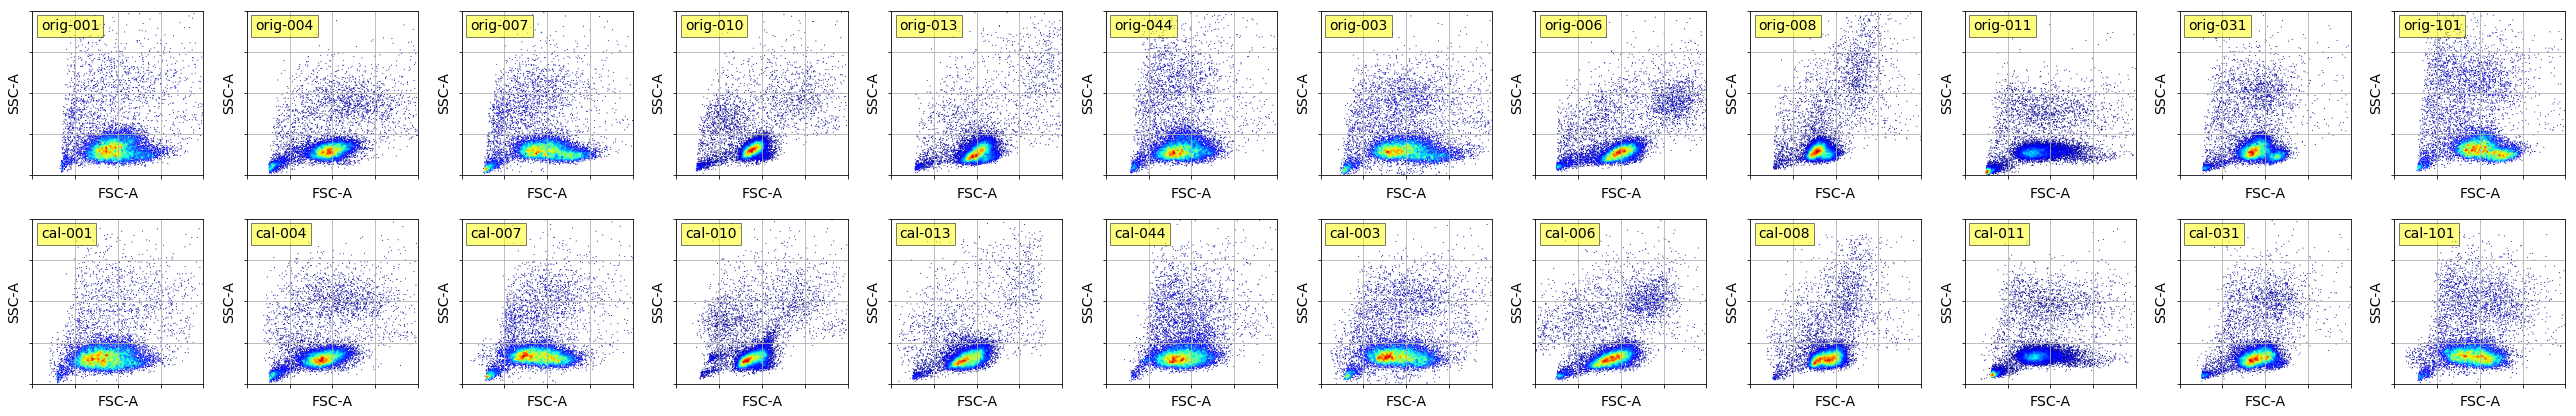

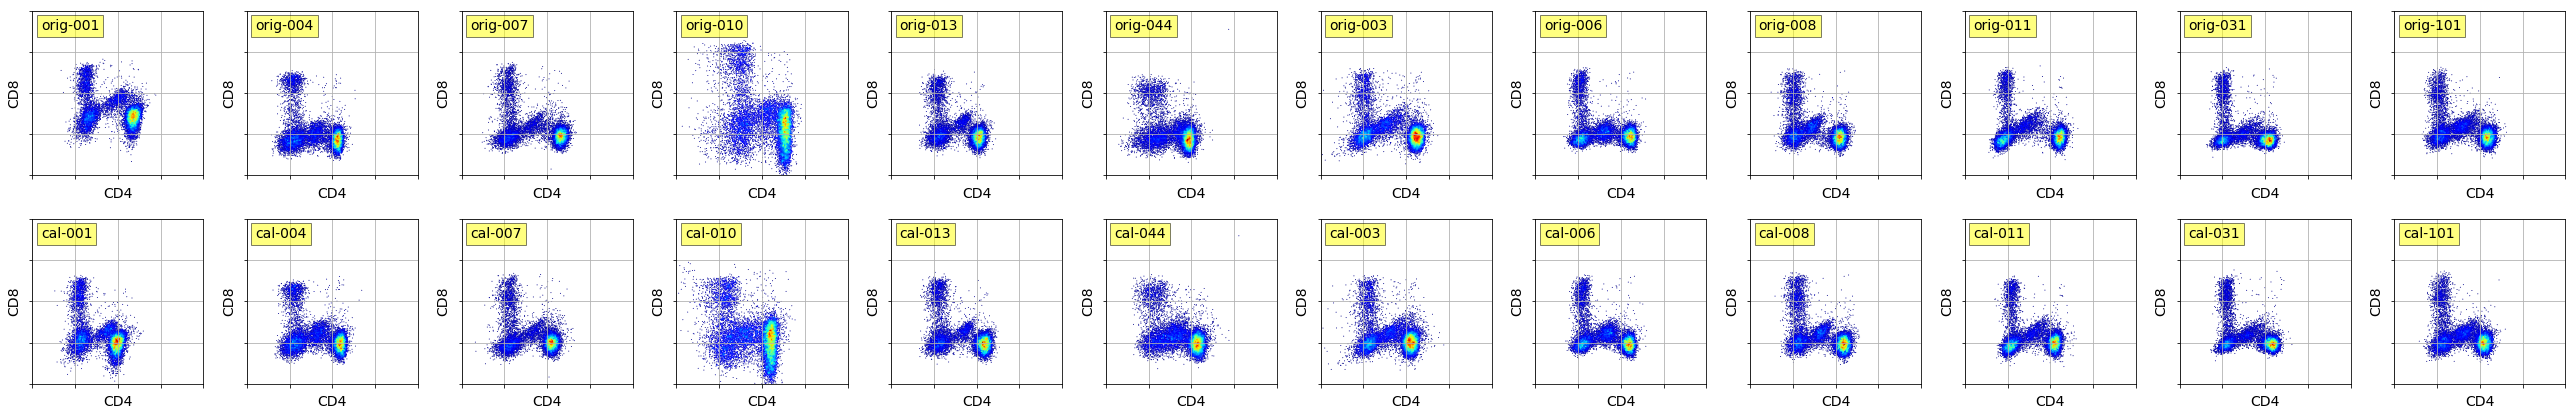

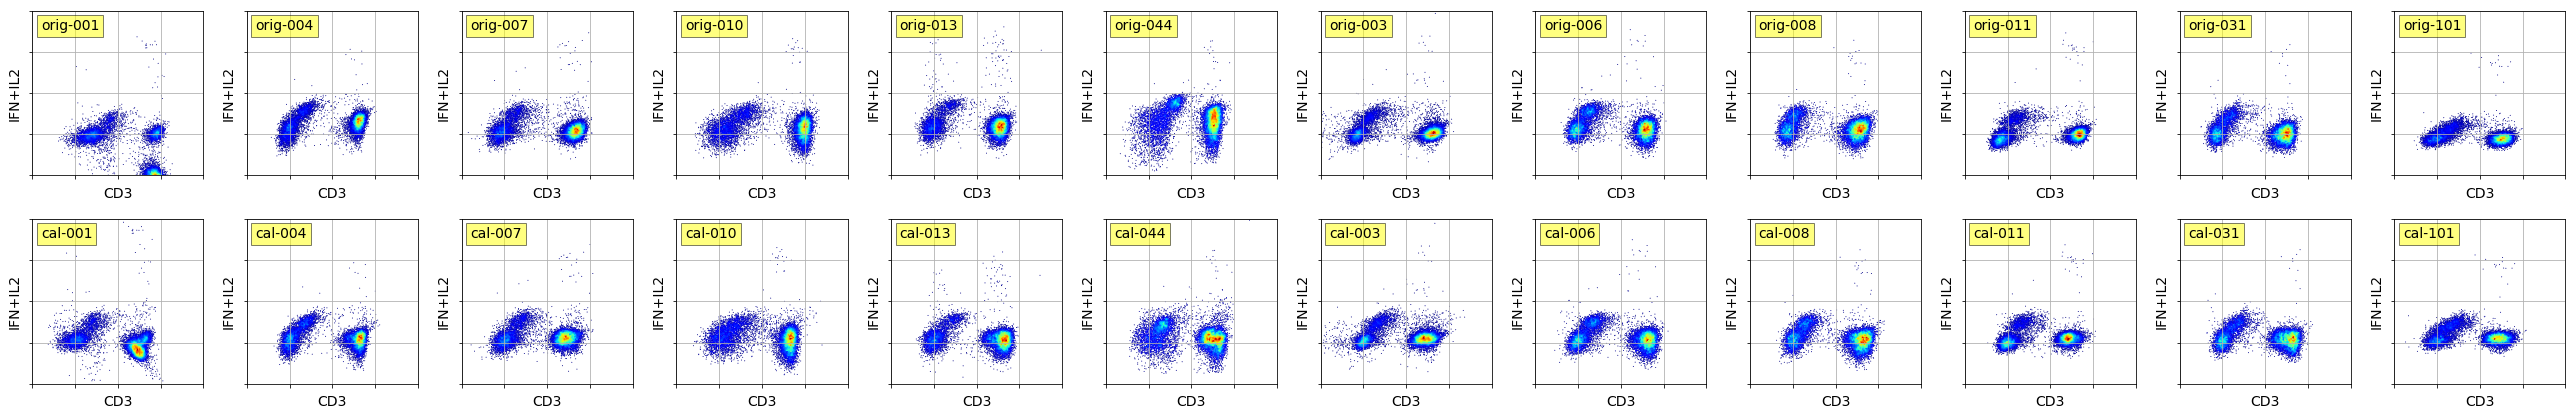

In [35]:
nrows = len(data_sets)
ncols = len(labs)

for k in range(len(dims)):
    dim = dims[k]
    ms = dim_markers[k]

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3))
    for i, label in enumerate(['orig', 'cal']):
        for j, lab in enumerate(labs):

            xs = data_sets[i][j]

            ax = axes[i, j]
            if k==0:
                ax.set_xlim([0, 262144])
                ax.set_ylim([0, 262144])
                xmin = ymin = 0
                xmax = ymax = 262144
            else:
                ax.set_xlim([-10000, 100000])
                ax.set_ylim([-10000, 100000])
                xmin = ymin = -10000
                xmax = ymax = 100000

            x = xs[:, dim[0]]
            y = xs[:, dim[1]]
     
            z = bilinear_interpolate(x, y)
            ax.scatter(x, y, c=z, s=1, edgecolors='none', cmap='jet')
            ax.set_xticks(np.linspace(xmin, xmax, 5))
            ax.set_yticks(np.linspace(ymin, ymax, 5))
            ax.set_xticklabels([])
            ax.set_yticklabels([])   
            ax.set_xlabel(ms[0])
            ax.set_ylabel(ms[1])

            ax.text(0.05, 0.95, '%s-%s' % (label, lab), 
                    va='top', ha='left', transform=ax.transAxes,
                    bbox=dict(facecolor='yellow', alpha=0.5))
            ax.grid(True)
    fig.tight_layout()      
    fig.savefig('figs/%s-%s-%s.png' % (label, '_'.join(ms), ident[:-4]))